# Analysis of Select NUSC Collections' Metadata

In [39]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
nltk.download('tagsets')  # part of speech tags
from nltk.draw.dispersion import dispersion_plot as displt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [2]:
f = "data/extracted/nusc_archival_descs_for_clf.csv"
# f = "data/extracted/newcastle_archival_metadata_sample.csv"

In [3]:
df = pd.read_csv(f, index_col=0)
print(df.shape)
df.head()

(57947, 5)


,description_id,eadid,rowid,field,doc
0,0,BP,BP,processinfo,This EAD description created by Ruth Sheret 27...
1,1,BP,BP,scopecontent,The papers of the distinguished public servant...
2,2,BP,BP,unittitle,Plowden (Lady Bridget) Archive
3,3,BP,BP/01,scopecontent,"Formerly the 'Working Ladies Guild', the organ..."
4,4,BP,BP/01,unittitle,Chairman (Managing Committee) of the Mary Fiel...


In [4]:
df.field.unique()

array(['processinfo', 'scopecontent', 'unittitle', 'bioghist',
       'extent-and-medium', 'title', 'description'], dtype=object)

Comment/uncomment the selection of descriptions to analyze:

In [98]:
# all = list(df["doc"])
# all[0]

# pi = list(df.loc[df["field"] == "processinfo"].doc)
# pi[0]

# sc = list(df.loc[df["field"] == "scopecontent"].doc)
# sc[0]

# bh = list(df.loc[df["field"] == "bioghist"].doc)
# bh[0]

ut = list(df.loc[df["field"] == "unittitle"].doc)
ut[0]

# Gertrude Bell Archive metadata only
# ------------------------------------
# em = list(df.loc[df["field"] == "extent-and-medium"].doc)
# em[0]

t = list(df.loc[df["field"] == "title"].doc)
t[0]

# d = list(df.loc[df["field"] == "description"].doc)
# d[0]

'Letter from Gertrude Bell to her stepmother, Dame Florence Bell'

In [99]:
descs = ut + t

## Exploratory Analysis

In [100]:
sentences = [sent_tokenize(d) for d in descs]
print(sentences[1])

['Chairman (Managing Committee) of the Mary Fielding Guild, 1945 - 1988']


In [101]:
tokens = [word_tokenize(d) for d in descs]
print(tokens[1])

['Chairman', '(', 'Managing', 'Committee', ')', 'of', 'the', 'Mary', 'Fielding', 'Guild', ',', '1945', '-', '1988']


In [102]:
tokens_flat_lower = [t.lower() for token_list in tokens for t in token_list]
print(tokens_flat_lower[:10])

['plowden', '(', 'lady', 'bridget', ')', 'archive', 'chairman', '(', 'managing', 'committee']


In [103]:
total_sentences = sum([len(s) for s in sentences])
total_tokens = len(tokens_flat_lower) #sum([len(t) for t in tokens])
print("Total sentences: ", total_sentences)
print("Total tokens: ", total_tokens)

Total sentences:  30189
Total tokens:  223708


In [104]:
print("Unique tokens: ", len(set(tokens_flat_lower)))

Unique tokens:  6911


In [105]:
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(string.digits))

In [106]:
print(stop_words)

{'just', "you'll", 'herself', 'ourselves', 'you', '`', 'don', '9', 'doing', '+', 'as', '[', 'after', "she's", 'down', 'are', 'its', 'did', 'm', 'your', "'", 'a', ';', 'will', 'not', 'before', 'isn', 'is', 'the', 'off', "he's", "they've", "wasn't", "we'll", 'aren', "should've", '5', 'by', "doesn't", 'during', '2', 'or', '!', '}', 'won', "he'd", "we're", "you're", "i've", 'an', 'was', "wouldn't", 'other', 'under', 'himself', 'he', "it'd", 'were', '|', 'has', "they'd", 'where', 'these', 've', 'be', "isn't", 'through', 'only', '.', 'they', 'him', ',', 'wouldn', '"', 'hasn', 'hers', 'until', 'd', 'me', "mustn't", 'nor', "shouldn't", 'wasn', 'o', 'hadn', 'because', 'been', "i'm", 'do', 'out', "shan't", 'her', "weren't", 'can', "he'll", 'ma', 'what', '*', 'at', "we've", 'then', '<', 'ours', 'theirs', '(', 'am', 're', '%', 'doesn', '-', 'them', "they're", '?', 'whom', 'few', 'does', '3', 'up', "aren't", 'further', 'we', "it'll", 'our', 'myself', '1', ']', 'in', "don't", 'against', 'needn', 'ho

### Root Forms: Lemmatize & Stem

In [107]:
wnl = nltk.WordNetLemmatizer()
lemmas = [wnl.lemmatize(t) for t in tokens_flat_lower if t.isalpha()]
filtered_lemmas = [l for l in lemmas if l not in stop_words]
print("Total lemmas: ", len(lemmas))
print("Total filtered lemmas: ", len(filtered_lemmas))
print("Unique lemmas: ", len(set(lemmas)))
print("Unique filtered lemmas: ", len(set(filtered_lemmas)))


Total lemmas:  185859
Total filtered lemmas:  136988
Unique lemmas:  5561
Unique filtered lemmas:  5465


In [108]:
ps = PorterStemmer()
stems = [ps.stem(t) for t in tokens_flat_lower if t.isalpha()]
filtered_stems = [s for s in stems if s not in stop_words]
print("Total stems: ", len(stems))
print("Total filtered stems: ", len(filtered_stems))
print("Unique stems: ", len(set(stems)))
print("Unique filtered stems: ", len(set(filtered_stems)))

Total stems:  185859
Total filtered stems:  137018
Unique stems:  5208
Unique filtered stems:  5121


In [109]:
print(lemmas[100:110])
print(stems[100:110])

['working', 'party', 'no', 'draft', 'of', 'the', 'final', 'report', 'evidence', 'and']
['work', 'parti', 'no', 'draft', 'of', 'the', 'final', 'report', 'evid', 'and']


### Frequency Distributions

In [110]:
filtered_tokens = [t for t in tokens_flat_lower if t not in stop_words]
filtered_tokens = [t for t in filtered_tokens if t.isalpha()]
print("Total alphabetic tokens:", len(filtered_tokens))

Total alphabetic tokens: 136996


<Axes: title={'center': 'Top 30 most common alphabetic tokens'}, xlabel='Samples', ylabel='Counts'>

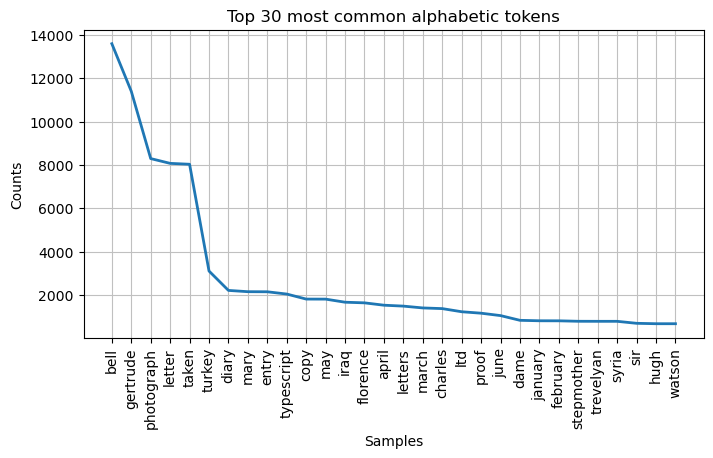

In [111]:
fdist_tokens = FreqDist(filtered_tokens)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30
fdist_tokens.plot(n, title=f"Top {n} most common alphabetic tokens")

<Axes: title={'center': 'Top 30 most common lemmas'}, xlabel='Samples', ylabel='Counts'>

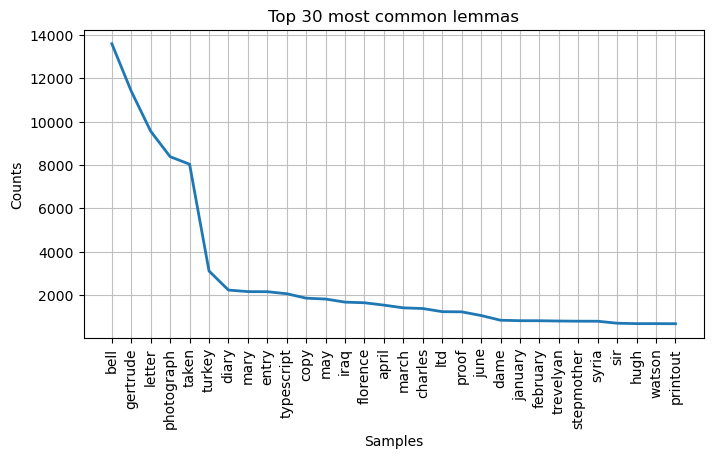

In [112]:
fdist_lemmas = FreqDist(filtered_lemmas)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30 #10
fdist_lemmas.plot(n, title=f"Top {n} most common lemmas")

<Axes: title={'center': 'Top 30 most common stems'}, xlabel='Samples', ylabel='Counts'>

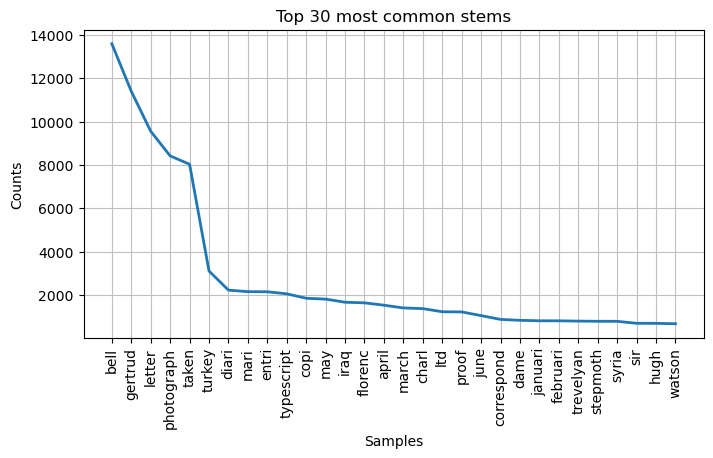

In [113]:
fdist_stems = FreqDist(filtered_stems)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30 #10
fdist_stems.plot(n, title=f"Top {n} most common stems")